_

<img src="../Resources/Images/Slides-Logo.png" alt="Drawing" style="width: 500px;"/>

<center> <a href='https://www.linkedin.com/in/raulm8/'>by Raul Maldonado</a></center>

# 1.0 The Overview


## 1.1 Introduction

* Resources

    * **Repository Link:** [http://bit.ly/Raul-ABTesting-PyDataLA](http://bit.ly/Raul-ABTesting-PyDataLA)
    * **Google Colab version** of [this Jupyter Noteobok](https://colab.research.google.com/drive/1AhcqoS584byUUwmjvimnxEpn1ho9n0uV#offline=true&sandboxMode=true)


* About Me:

    * Data Analyst @Autodesk.
    
    * Enjoying coffee, running, and working on side projects...whenever I can.

____
Today you'll have the opportunity to learn "online experimentation" scenario with A/B testing in Python.


> Note: There exists **proprietary** A/B testing solutions like [Optimizely](https://www.optimizely.com/), [VWO](https://vwo.com/campaign/get-started/?utm_source=google&utm_medium=paid&utm_campaign=mof_search_brand_vwo_brand&utm_content=308583203468&utm_term=vwo&gclid=Cj0KCQjwv8nqBRDGARIsAHfR9wD7uaDnZRUDFKrXDtcn8jCv4v_dNhSRxzWsddKQAo0WuREO4phZ1PQaAopsEALw_wcB), [AB Tasty](https://www.abtasty.com/), [Google Optimize](https://optimize.google.com/optimize/home/). Moreover, there are *Open Source* functions in solutions like Scipy, StatsModel, packages Planout, Wasabi, and more. 
>
>However, this presentations shows the raw formualization for constructing an A/B test.

**Information and data presented today is in no affiliation with Autodesk.**



**Agenda:**

1. Intro to Statistics [Pre]
2. Overview of AB Testing
3. AB Testing Implementation
4. Results
5. Ending & Remarks

Enjoy! :D
____

In [1]:
#OS Items
import os
import warnings
warnings.filterwarnings("ignore")

#Data Objects
import pandas as pd

# Statistical Packages
import scipy
import numpy as np


#Visualizations
import seaborn as sns
sns.set_style("dark")
import matplotlib.pyplot as plt



In [2]:
### Note: If package faker is not installed, 
##### comment and apply the below package.
# !pip install faker

# Other Packages
# !conda install pandas
# !conda install scipy
# !conda install numpy
# !conda install seaborn

## 1.2 Scenario 


### 1.2.1 Existing Process

A user enter's a search into Google Search. 

Thereafter, they receive a particular set of results, including paid recommendations (Ads) at the top of their ranked search results.

Now, let's say we have an existing Ad A implemented to potentially be on that particular search. The user from above may click on the Ad. To increase the odds of them clicking the Ad A, we have a particular **Call to Action** "Click here, please!".

The Ad's activity from a user is logged either as a "Click" or a "No Click", like so

| Date     | Campaign  | User Email       | Action  |
|----------|---|---------------------|------------|
| 7/1/2019 | B |fake.email@comkast.net   | No Click |
| 7/1/2019 | A |real.email@goog1e.com | Click      |
| 7/4/2019 | A |real1.email@yawhoooo.com | Click |

> Notice Ad Campaign B. It's an equivalent Ad to A, with a different Call to Action. This is shown later.

### 1.2.2 Experiment Goals 

From the Ad, we would hope to get users to enter our website. 

Now, there are motivations for a user to enter our site, ~~like seeing if the new campaign will generate more money for our business~~. However, we start off with something more straightforward leading into that portion of the lifecyle. Particularly, we want a user to enter our site, the first step.


![Clicks](https://media.giphy.com/media/3ogwG8ByATNb5EOm8E/giphy.gif)

Before proceding further into further steps of the A/B testing overview, let's:

1. Import our fake data
2. Review some statistical items using Ad Campaign A...

# Create Fake Data

In [3]:
# [Optional, Ignore]--Create Fake Dataset:

def campaign_period(startDate, endDate):
    '''
    @return: Array of values between two periods
    '''
    from datetime import datetime, timedelta
    
    endDate_dt = datetime.strptime(endDate, '%m-%d-%Y')
    startDate_dt = datetime.strptime(startDate,'%m-%d-%Y')
    numberOfDays = (endDate_dt - startDate_dt).days
    date_list = [endDate_dt - timedelta(days=x) for x in range(numberOfDays)]
    date_list.append(startDate_dt)
    
    return(date_list)
    #Inspiration via  https://stackoverflow.com/questions/993358/creating-a-range-of-dates-in-python
    
    
def campaign_dataset_generator(campaignName = 'PersonDoe-Campaign2019-n', \
                               weightArray=[.5,.5], sample_size = 100, \
                               timeframe = ['10-1-2019', '12-03-2019']):
    '''
    @return: Generate Campaign Dataset, from generated data
    '''
    import random
    from faker import Faker
    faker = Faker()
    actions = ['Click','No Click']
    campaignActions = random.choices(actions,\
                        weights=weightArray,\
                        k=sample_size)
    
    campaignTimeFrame = campaign_period(timeframe[0],timeframe[1])
    generatedScenario = [[random.choice(campaignTimeFrame), campaignName, faker.email(), i] for i in campaignActions]
    return(generatedScenario)

def campaign_df_generator(matrix,columns):
    campaignsDataset = pd.DataFrame(matrix,\
                                columns = columns)
    '''
    @return: Generate Dataframe version of a Campaign Dataset
    '''  
    campaignsDataset.sort_values(by='Date',\
                             ascending=True, inplace = True)
    campaignsDataset = campaignsDataset.pivot_table(index=['Date','Campaign'],\
                                                columns='Action',\
                                                aggfunc='size',\
                                                fill_value=0).reset_index(drop=False)
    
    campaignsDataset[['Click','No Click']] = campaignsDataset[['Click','No Click']].astype(float)

    campaignsDataset.rename_axis(None, axis=1, inplace=True)
    
    uniqueCamp =campaignsDataset['Campaign'].unique()
    returnedObjects = []
    
    for element in uniqueCamp:
        returnedObjects.append(campaignsDataset[campaignsDataset['Campaign'] == element])

    return(returnedObjects)

# A hack way to generate two Ad Campaign datasets
def express_campaign_df_generator(campaignList,weightMatrix, sample_size):
    firstCamp = campaign_dataset_generator(campaignList[0],weightMatrix[0], sample_size)
    secondCamp = campaign_dataset_generator(campaignList[1],weightMatrix[1], sample_size)
    combinedCampaigns = [*firstCamp, *secondCamp]
    # https://stackoverflow.com/questions/1720421/how-do-i-concatenate-two-lists-in-python
    
    columns = ['Date','Campaign','User_ID','Action']

    dfs = campaign_df_generator(combinedCampaigns, columns)
    
    return(dfs)

In [4]:
# Custom distribution plot function.
# Function uses Seaborn's Distplot.

def distribution_plot(series, series2=None, name_of_campaign = ''):

    sns.distplot( series['CTR'], hist=True, kde=True, \
        kde_kws = {'shade': True, 'linewidth': 3})

    plt.title(f'Campaign {name_of_campaign}\'s Success Distribution')

    plt.xlabel(series['CTR'].name)
    plt.show()

In [5]:
## Dataset size 
size = 1600

In [6]:
campaign1_name = 'PersonDoe-Campaign2019-1'
campaign2_name = 'PersonDoe-Campaign2019-2'

# Generate first Campaign Dataset
firstCampaign_ds = campaign_dataset_generator(campaignName = campaign1_name, \
                                           weightArray = [.5, .5], \
                                           sample_size = size)
# Generate second Campaign Dataset
secondCampaign_ds = campaign_dataset_generator(campaignName = campaign2_name, \
                                            weightArray = [.53, .47], \
                                            sample_size = size)

# Concatenate datasets (particularly, matrices/arrays)
combinedCampaigns = [*firstCampaign_ds, *secondCampaign_ds]

columns = ['Date','Campaign','User_ID','Action']

# Generate dataframe with combined Ad Campaign 1 & 2 datasets
dfs = campaign_df_generator(combinedCampaigns, columns)

campaign1 = dfs[0].reset_index(drop=True)
campaign2 = dfs[1].reset_index(drop=True)

In [7]:
# Check out the first 3 rows of dataframe campaign1
campaign1.head(3)

,Date,Campaign,Click,No Click
0,2019-10-01,PersonDoe-Campaign2019-1,9.0,12.0
1,2019-10-02,PersonDoe-Campaign2019-1,15.0,10.0
2,2019-10-03,PersonDoe-Campaign2019-1,13.0,14.0


In [8]:
# Check out the first 3 rows of dataframe campaign2
campaign2.head(3)

,Date,Campaign,Click,No Click
0,2019-10-01,PersonDoe-Campaign2019-2,13.0,10.0
1,2019-10-02,PersonDoe-Campaign2019-2,15.0,13.0
2,2019-10-03,PersonDoe-Campaign2019-2,17.0,9.0


## 1.3  Stats 101, a brief review [Optional]

Some of the utilized Statistical concepts:

| Name     | Definition          | 
|----------|-----------------------|
| Mean ($\mu$) | $\tfrac{\sum_{i=1}^N  X_i}{n}$  |
| Variance $ (\sigma^2$) | $ \tfrac{\sum_{i=1}^N {(x_i -\mu)^2}}{N}$| 
| Standard Deviation ($\sigma $) | $ \sqrt{ \tfrac{\sum_{i=1}^N {(x_i -\mu)^2}}{N}} $  |



### 1.3.1 Mean

Observing Ad A, the (Arithmetic) $\text{Mean}$ $\mu$ calculates the total sum of values divided by the the total count of values being summed up, 
or $\mu = \tfrac{\sum_{i=1}^N {x_i}}{N}$


E.g.

In [9]:
# For some given set of values generated from the fake data we created, 
# we calculate the average of the first 5 "Click" values.

firstFiveValues = campaign1.Click[:5]

testMean_numerator = firstFiveValues.sum()
testMean_denominator = firstFiveValues.size

testMean = testMean_numerator / testMean_denominator

In [10]:
testMean

11.2

In [11]:
print(f"We have the array {list(firstFiveValues)}. \n\nTaking the total sum, {testMean_numerator},", 
      f"and then dividing by the size {testMean_denominator}", 
      f", we get an average of...\n{testMean_numerator}/{testMean_denominator} = {testMean}")

We have the array [9.0, 15.0, 13.0, 6.0, 13.0]. 

Taking the total sum, 56.0, and then dividing by the size 5 , we get an average of...
56.0/5 = 11.2


### 1.3.2 Variance & Standard Deviation

Variance is the measure of spread of a given set of values. Alternatively, it can be formulaically said that it is the average of the squared differences from the mean, seen below.

$ \text{Variance} = \tfrac{\sum_{i=1}^N {(x_i -\mu)^2}}{N}$


In [12]:
testVar_numerator_step_1 = [firstFiveValues - testMean]
testVar_numerator_step_2 = np.power(testVar_numerator_step_1, 2)
testVar_numerator = testVar_numerator_step_2.sum()

testVar_denominator = (testMean_denominator)

testVar = testVar_numerator/testVar_denominator

In [13]:
testVar

10.559999999999999


Taking the squared root of the variance, we have a measure of spread in the same units as the spread. 
> That being said, we see that the Variance and Standard Deviation being related.

$\sqrt{\text{Variance}} = \sqrt{\sigma ^2} =  \sigma  = \sqrt{ \tfrac{\sum_{i=1}^N {(x_i -\mu)^2}}{N}} = \text{Standard Deviation} $

In [14]:
testStd = round(np.sqrt(testVar), 3)

In [15]:
print(f"We have array {list(firstFiveValues)}, with mean {testMean}.",
      f" \n\nTaking summed squared difference from the mean, {testVar_numerator},", 
      f"and then dividing by the 'size - 1', {testVar_denominator},", 
      f"we get a variance of...\n{testVar_numerator}/{testVar_denominator} = {testVar}.\n", 
      f"Lastly, taking the square root of the variance, we get a Standard Deviation of...{testStd}")

We have array [9.0, 15.0, 13.0, 6.0, 13.0], with mean 11.2.  

Taking summed squared difference from the mean, 52.8, and then dividing by the 'size - 1', 5, we get a variance of...
52.8/5 = 10.559999999999999.
 Lastly, taking the square root of the variance, we get a Standard Deviation of...3.25


# 2.0 A/B Testing


Now, let's come back to our A/B Testing discussion. 

Recall we had deployed two digital ad campaigns A and B. Moreover, recall [Campaign A](https://codepen.io/cloudchaoszero/full/JjooEbJ) has some _Call to Action_ **"Click here, please!"**.

Now, let [Ad B](https://codepen.io/cloudchaoszero/full/xxbbgLr) be a replica of A, but with a subtle change to the Call to Action text, being **_"Learn more here!"_**. 


We want to understand the performance between each campaign. 

Should we just "eye" the performance of these two campaigns, and make a conclusion? If not, what's the more methodic/statistical approach to comparing the performances between these two Ads?

One statistical method we can turn to is A/B Testing.

What is A/B Testing?

**A/B Testing** is "[a randomized online experiment of two variants, A and B.](https://en.wikipedia.org/wiki/A/B_testing)” This test quantitatively compares two samples with a single "metric of choice" in evaluation to determine if there exists a statistical significance between them.

They are essentially a modern, online, adaptation of statistical experiment frameworks called Hypothesis tests. 

> Commentary: There are those that surley do believe A/B tests are distinct from Hypothesis tests, given the difference in nature of experimentation setup from Academia, etc. 
>
>However, there are many that believe  A/B tests was borrowed from the Statistics world, and labeled an edgy/cool name to distinguish iteself. #Marketing 

![Not Lame](../Resources/Images/not_lame_meme.png)   

## 2.1 A/B Testing Background

A "high-level" overview of A/B testing can be illustrated in the following:

For some test metric, 

![AB Testing Format](../Resources/Images/ABTesting-Format.png)

(**Source**: [“Probably Overthinking It” by Allen Downey](http://allendowney.blogspot.com/2016/06/there-is-still-only-one-test.html))


In more depth for the test-statistic step:

If you observe the following diagram of choices below, notice one has to select the right calculation & criteria for their experiment. They have to consider assumptions like data distribution, data types, number of samples, and other assumptions.

Student's introduction to Statistics can involve the following tree of decisions:


![Tree](../Resources/Images/AB-Testing-Choices-Tree.png)

[Source](https://bloomingtontutors.com/blog/when-to-use-the-z-test-versus-t-test)

________

> **Commentary:** Other mentions or comparisons between Z-test & T-test, $\chi^2$ test, and other items from the above may be covered in the Appendix section, or referenced repository, seen in the **"Additional Information"** section.

![Sleepy](../Resources/Images/tired_gif.gif)


Now, let's get started with a practice run of A/B Testing.

We keep in mind of the following procedure:

1. State your Hypothesis 
2. Statistical Assumptions
3. Define and collect control group information
4. Identify you Minimum Detectable Effect, Sample Size, and more
5. Analyze
6. Conclusion

> Commentary: Carefully implementing these procedures in one's experiment, we ensure a resound testing framework & reduced risk of incorrect results.

## 2.2 Testing, Testing..1,2,3.



### 2.2.0.1 Metric Of Choice

Recall we want to evaluate the performances of Ads A & B for users entering our website. Seeing these changes of the click interaction of our Ads, we want to observe  the Click Through Rate (CTR) performance. Therefore, CTR is our Metric of Choice for our AB Test.

Let the CTR proportion $\hat{p}_i$ be defined as $\hat{p}_i = \tfrac{\text{Total Number of Successes}}{\text{Total Number of Events}} = \tfrac{x_i}{n_i} $ 

where 

$x_i$ are the successes 
& 
$n_i$ is the total count of each sample.

> Note: those who 'click' an Ad is a binary metric, a user either clicks the button at some point, or she/he does not.
>
> Note: There are other evaluation metrics for variant variables

## 2.2.1 State Your Hypothesis


We would like to observe if there is a difference in performance between the two Ads. Particularly, we want to observe if there is a statistically significant difference in their CTR performance.

Let $\hat{p_1}$ = $\text{CTR}_{\text{Campaign A}}$  and $\hat{p_2}$  = $\text{CTR}_{\text{Campaign B}}$ be the CTR proportions for campaign A & B, respectively.

where $\hat{p}:= \tfrac{\text{# of Clicks}}{\text{Total # of events}}$


We state:

$H_0: \hat{p_1} = \hat{p_2}$ , or $d = 0$


$H_A: d \neq 0$

, where $d = \hat{p_1} - \hat{p_2} $

We would establish a Level of Significance, $\alpha$. 

Set $\alpha = .05$. 

In [16]:
# Significance level
alpha = 0.05

From the notation above,

We are saying for a default assumption that there is no difference between Ad Campaign A and Campaign B. However, the Alternative Hypothesis $H_A$ there is a significant difference between Ad Campaign A and B.

Although, we had choosen 1 of 3 hypotheses to consider in a test. 

What are the other permutations for stating our initial hypothesis?

### 2.2.1.1 The statements

In a different context, under the assumption of our $H_0: \mu = \text{value}$,

Let $H_0$ be our Null Hypothesis, the statement saying the comparison between the average of a population and a sample value has no observed differences, statistical differences.

Let $H_A$, $H_1$, be our Alternative Hypothesis, the statement saying the comparison between the average of a population and a sample value does has observerd statistical difference.

However, we can also say:

![Types of Test](../Resources/Images/two_tailed_test.png)

[Source](https://www.fromthegenesis.com/difference-between-one-tail-test-and-two-tail-test/)


And it should be noted here that we are **not trying to prove , $H_a$, that there is a significant difference between the groups**. 

Rather, we are observing from the standpoint of no difference to see if one exists.


> Commentary: Imagine being in a state of being leanient to be proven guilty until proven guilty, compared to innocent until proven so. Similar to being a judge, one is highly recommended to approach an evaluation under standpoint of neutrality.

> ![Court](../Resources/Images/innocent_court.gif)

But wait, what about  $\alpha$ value?

### 2.2.1.2 $\alpha$, and Outcomes from Decisions


$\alpha$ is our **Level of Significance**. 

It is the the probability of the study rejecting the null hypothesis $H_0$, given that the null hypothesis were true.
 
Similarly, we have the Confidence Level, $1-\alpha$. The Confidence Level is our probability of failing to reject the null hypothesis, given that it is true. 

However, there are two more calculated scenarios one must consider from their decision, $\beta$ & $1-\beta$.

$\beta$ is the probability of failing to reject the null hypothesis $H_0$, when $H_0$ is False.

> That is, what is the probability of sticking to our ways given that there is statistical evidence an alternative scenario exists?

And the last probability to mention is $1- \beta$, which is the probability of rejecting the null hypothesis $H_0$, when $H_0$ is false. This is called the **Power** of a test. 

> Commentary: Traditionally the Power is expected to be .80, like the default of $\alpha = 0.05$

The following is a visual representation of these decisions:

In matrix form,

![AB Testing Decisions](../Resources/Images/ab_testing_choices.png)

[Source](https://www.abtasty.com/blog/type-1-and-type-2-errors/)

_

![MDE n'Alpha graph](../Resources/Images/decision_outcomes_ab_test.jpg)

[Source](https://upload.wikimedia.org/wikipedia/commons/thumb/3/30/H0_h1_fehler.jpg/512px-H0_h1_fehler.jpg)

### 2.2.1.3 Basic Assumptions <span style='color:red'>*</span>

From the collected samples for this type of targeted data, we assume the following conditions:

* Each click event is independent from one another

* We have a Simple Random Sample

* A user either clicks or does not click (leaves an impression)

* Assumption of Central Limit Theorem. (Allows for the assumption of a normal distribution)

    * With an appropriate traffic size, the binomial-like distribution of this scenario reaches a Standard Normal (Gaussian) Distribution

* We have a consideration of invariant and variant metrics for our experiment

#### 2.2.2 Data Transformation [Misc.]

In [17]:
# # Confirm Dataset Schema
print(f'DataFrame Schema:\n{campaign1.columns.tolist()}')

DataFrame Schema:
['Date', 'Campaign', 'Click', 'No Click']


We observe that the dataframe contains dimension information, along with measures like Clicks and No Clicks.

**Question**

Recall the CTR formula from before. 

Create a column 'CTR' in the both dataframe's _campaign1_ and _campaign2_

**CTR** $:= \tfrac{\text{?}_1}{\text{?}_2}$

Hint: Our "Metric of Choice"

In [18]:
# Calculate the CTR for Ad Campaign 1's column campaign2['CTR']
campaign1['CTR'] = campaign1['Click'] / (campaign1['No Click'] + campaign1['Click'])

# Calculate the CTR for Ad Campaign 2's column campaign2['CTR']
campaign2['CTR'] = campaign2['Click'] / (campaign2['No Click'] + campaign2['Click']) 

The daily CTR distributions are as followed:

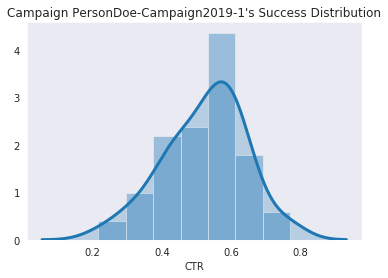

In [19]:
# Establish the 1st campaign's distribution
distribution_plot(series = campaign1, name_of_campaign= campaign1_name)

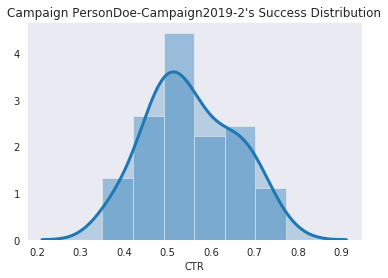

In [20]:
# Establish the 2nd campaign's distribution

distribution_plot(series = campaign2, name_of_campaign= campaign2_name)

In [21]:
# CTR Proportion Calculations

n1 = (campaign1['No Click'].sum() + campaign1['Click'].sum())
# p = x/n
p1 = campaign1['Click'].sum() / n1

n2 = (campaign2['No Click'].sum() + campaign2['Click'].sum())
# p = x/n
p2 = campaign2['Click'].sum() / n2

In [22]:
print(f'Ad Campaign 1: CTR = {p1}, from Total Occurences are {n1}')

print(f'Ad Campaign 2: CTR = {p2}, from Total Occurences are {n2}')

Ad Campaign 1: CTR = 0.521875, from Total Occurences are 1600.0
Ad Campaign 2: CTR = 0.555625, from Total Occurences are 1600.0


## 2.3 Analyze The Results <span style='color:red'>*</span>

In the calculation options covered in the AB Testing overview portion, we saw that a calculation is considered and dependent on the nature of the question and type of metric calculated. In this particular case, we will be using the $t$ statistic b/t two binomial distributed groups, defined as 

$t= (\tfrac{ \hat{p_1} - \hat{p_2} - 0 }{SE}) = \tfrac{ d - 0 }{SE}$, 

where the standard error $SE = \sqrt{(\tfrac{\hat{p_1} (1-\hat{p_1})}{n_1}) + (\tfrac{\hat{p_2} (1-\hat{p_2})}{n_2})}$

> Note: 
> 1. When comparing between two groups, the notation $d:=\hat{p_1} - \hat{p_2}$ is introduced to simplify formula.
> 2. This is considered a independent t-test with equal variance, and not a dependent t-test w or without equal metrics



Additionally, we set our Degrees of Freedom for these two variants, defined as $DoF := (n_1 + n_2 -2)$. 

Using this DoF, we calculate the estimated $t^*$ value as a our threshold level for determining statistical significance.

### 2.3.1 Manual Approach

For the following function, calculate the difference d, standard error, and t-statistic. Moreover, determine the resulting decision for this particular case.

In [23]:
def ind_t_test(group1, group2, alpha = 0.05, output_bool=False, state_conclusion =False, express=False):
    
    
    '''
    ind_t_test Function for manual calculation of Independent T Tests for CTR.
    
    Parameters:
    * group1: Test Group #1 (Dataframe)
    * group2: Test Group #2 (Dataframe)
    * alpha: Alpha is the Test of Significance
    * output_bool:
    * state_conclusion:
    * express:
    
    
    Return:
    * 1x2 Array of Click Through Rate (CTR) values. 
    * 1x2 Array of total N for each campaign. 
    * 1x2 Array of Standard Errors for each campaign. 
    * Standard Error value.
    * T-Statistic value.
    * T-Critical value.
    * Confidence Interval   
    * Calculated P-Value
    '''
    
    # Step 1: Take the proportions of provided datasets:
    ## Create the proportion calculations: p_1, p_2 for the
    ## difference d. 
    ## The first calculation step for our test.
    
    n1 = (group1['No Click'].sum() + group1['Click'].sum())
    p1 = group1['Click'].sum() / float(n1)

    n2 = (group2['No Click'].sum() + group2['Click'].sum())
    p2 = group2['Click'].sum()  / float(n2)

    d= p2 - p1

    # Step 2. Obtain the Standard Deviation:
    #    - Combined group Standard errors  
    ## Calculate the Standard Error for each proportions.
    ## This allows us to set up for the t-statistic calculation.
    p_overall = (group1['Click'].sum() + group2['Click'].sum() )/ (n1+n2)
    
    # Term 1
    ## Calculate the first term p_1 * (1-p_1) /n_1
    se1 = (p_overall * (1 - p_overall))/n1
    
    # Term 2
    ## Calculate the first term p_2 * (1-p_2) /n_2
    se2 = (p_overall * (1- p_overall))/n2
    
    ## Terms being squared for final result.
    ### SE = sqrt( SE_1 + SE_2)
    standardError = np.sqrt(float(se1) + float(se2))
    
    print('SE 1:', standardError)

    #Step 3 t-statistic
    ## T statistic calculation.
    ### d / Standard Error, where d:= p2-p1
    tStatistic = (d-0) / standardError

    # Degrees of Freedom
    ### (n_1-1) + (n_2-1) = (n_1 + n_2 -2)
    dof = (n1 + n2 - 2.0)
    
    
    # Critical T Value Test Statistic
    criticalValue = scipy.stats.t.ppf(1.0 - alpha, df = dof)


    # Confidence Interval
    ### Tip: We'd like to avoid value of 0 in this CI
    confInt = [d - (criticalValue * standardError), d + (criticalValue * standardError)]

    
    # Second type of decision criteria: |t| >= |t^*|.
    

    # Step 4: Calculating p-value
    ## Two Sided P Value, P( |t| >= |t^*|).
    ### Calcualte the p-value using a Cumulative Density function
    ### from Scipy's stats.t.cdf(t-test, DoF) function
    
    p_val = (1 - scipy.stats.t.cdf(abs(tStatistic), df \
                                   = (n1 + n2-2)) ) * 2.0
    
    if output_bool is True:
        print('Analysis:\n\n')
        print(f'Campaign {group1.Campaign[0]}\'s CTR: {round(p1,4)}' \
              + f' with Standard Error {se1}.')
        print(f'Campaign {group2.Campaign[3]}\'s CTR: {round(p2,4)}' \
              + f' with Standard Error {se2}.\n')
        
        print(f"Confidence Interval {confInt}")
        print(f'T Statistic: {round(tStatistic, 2)}\n')
        
        print(f'We have critical value t^* at {round(criticalValue, 2)}' + \
              f'\nand p-value of {round(p_val, 2)}')
        
        print(f'\n\nComponents for variants Campaign {group1.Campaign[0]}\'s \n& ' + \
              f'Campaign {group2.Campaign[3]}\'s, respectively:')
        
        print(f'Difference d: {d}')
        
        print(f'SE terms within SE calculation: {[se1,se2]}')
        print(f'SE: {standardError}')
        
        print(f'Calcualted T-statistic: {tStatistic}')
        print(f'T critical value: {criticalValue}')
    
    
    #Step 5 Statemtent of declaration & Decision        
    if state_conclusion is True:
        if express is False:
            # Restate our decision process
            print('Conclusion:\n\n')

            print(f'If the p-value is less than our defined alpha = {alpha}, then we' +\
                  ' reject the null hypothesis H_0.\nIf not, then we fail to reject the' +\
                  ' null hypothesis H_0.')

            print(f'Confidence Interval: {confInt}')
            print(f'P-value: {p_val}')
            print(f'Alpha: {alpha}')
        
        if p_val < alpha:
            print('\nWe reject the Null Hypothesis H_0')
            print('Therefore, we can say that there is a statistical ' + \
            'difference between the two campaigns.')

        else:
            print('\nWe fail to reject the Null Hypothesis H_0')
            print('\nTherefore, we can say that there is no statistical' + \
            ' significant difference between the two campaigns.')
    return([p1,p2], [n1,n2], \
           [se1,se2], standardError, \
           tStatistic, criticalValue, \
           confInt, p_val)

If the calculated t-statistic $t$ > critical value $t^*$, then we reject the null hypothesis $H_0$, and accept the alternative hypothesis $H_A$.


> Equivalently, if $p < \alpha$, then we  reject the null hypothesis $H_0$, and accept the alternative hypothesis $H_A$.

> Ok.. what's a **P-value**? P-value is the probability of obtaining an effect at least as extreme as the one in your sample data, assuming null hypothesis is true.

(And again, the calculation does not measure in support for alternative hypothesis $H_A$.)

In [24]:
ctr, samples, \
sample_se, SE, \
tStat, tCrit, \
confidence_interval, p_val = ind_t_test(group1 = campaign1,
                                        group2= campaign2, \
                                        alpha = alpha,\
                                        output_bool = True, \
                                        state_conclusion=True)


SE 1: 0.01762450132273251
Analysis:


Campaign PersonDoe-Campaign2019-1's CTR: 0.5219 with Standard Error 0.0001553115234375.
Campaign PersonDoe-Campaign2019-2's CTR: 0.5556 with Standard Error 0.0001553115234375.

Confidence Interval [0.0047518749823046574, 0.06274812501769546]
T Statistic: 1.91

We have critical value t^* at 1.65
and p-value of 0.06


Components for variants Campaign PersonDoe-Campaign2019-1's 
& Campaign PersonDoe-Campaign2019-2's, respectively:
Difference d: 0.03375000000000006
SE terms within SE calculation: [0.0001553115234375, 0.0001553115234375]
SE: 0.01762450132273251
Calcualted T-statistic: 1.9149477980672556
T critical value: 1.645330241502658
Conclusion:


If the p-value is less than our defined alpha = 0.05, then we reject the null hypothesis H_0.
If not, then we fail to reject the null hypothesis H_0.
Confidence Interval: [0.0047518749823046574, 0.06274812501769546]
P-value: 0.05558827682985923
Alpha: 0.05

We fail to reject the Null Hypothesis H_0

There

### 2.3.2 Non-Manual Approach

We will use the package StatModel, with function [Proportion Z-Test](https://tedboy.github.io/statsmodels_doc/doc/generated/statsmodels.stats.proportion.proportions_ztest.html). 

In [25]:
# Try out the Proportion Z-Test from the StatModel library 
# statsmodels.stats.proportion.proportions_ztest()

from statsmodels.stats.proportion import proportions_ztest


trial_successes = np.array([campaign1['Click'].sum()  , \
              campaign2['Click'].sum()])
total = np.array([campaign1['No Click'].sum() + campaign1['Click'].sum(), \
              campaign2['No Click'].sum() + campaign2['Click'].sum()])

zTest_statistic, zTest_pval = proportions_ztest(trial_successes, total, value=0, alternative='two-sided')

print(f'StatModels\'s Calculated t-statistic is {round(zTest_statistic,4)}' + \
      f' and p-value is {zTest_pval}')

StatModels's Calculated t-statistic is -1.9149 and p-value is 0.05549916125449869


That's it, that's the test.

![Awk](../Resources/Images/awkward_meme.png)

Oh, but we should still respectively state our conclusion (for respect of the test)...

In [26]:
if zTest_pval < alpha:
    print('\nWe reject the Null Hypothesis H_0')
    print('Therefore, we can say that there is a statistical ' + \
    'difference between the two campaigns.')

else:
    print('\nWe fail to reject the Null Hypothesis H_0')
    print('\nTherefore, we can say that there is no statistical' + \
    ' significant difference between the two campaigns.')


We fail to reject the Null Hypothesis H_0

Therefore, we can say that there is no statistical significant difference between the two campaigns.


However, there can be some error in setup, calculation, introduction of bias, or another mistep in properly testing
With that being said, remember...


![Always be Testing](../Resources/Images/always_be_testing.png)


[“Ignorance more frequently begets confidence than does knowledge”](https://www.goodreads.com/quotes/24141-ignorance-more-frequently-begets-confidence-than-does-knowledge-it-is)

― Charles Darwin, The Descent of Man

# 3.0 Fin

# 4.0 Additional Content [Optional]

### 4.1 Segmentation

The type of users we are interested in depends on who our targeted audience is for this testing. 
(e.g. Do we simply sample from the overall population of this test, or are we evaluating performance between a particular group? 

From our previous mention of keywords, Google Ads enables us to selectively target our ads in a bid for certain types of keywords. If we win the bid, our ad is shown related to that keyword. 

> Note: If our segmentation is too specific, we lead into the impliciation of incorrectly rejecting our existing, null, hypothesis for another--something called the **Simpson's Paradox**. This is because the more refined our segmentation is, we target a specific case or decrease our # of observations such that we lead to those results.

> Luckily, to best audit that one can identify if the culmination of different segments have the same results as the total sample 

That is, identify if segments $A_n$, where $n \in {1,2,...n}$'s overall results hold true for sample $A$

![Simpon's Paradox Example](../Resources/Images/simpons_paradox_example.png)

* Mind the possibility of the Simpson's Paradox
    * Segmentation of groups in thus reducing sampling creates significance, but not from other groups from data before segmentation. Best way to validate this doesn't exist is to do the same test for combined groups.
        * E.g. Splitting between new users and existing users
* $\alpha$ percent of the time, you'll reach significance due to chance 
    * You are running a tests with 20 variants, and you test each hypothesis separately:
        * P(one significant result) = 1−P(no significant results) 
        * P(one significant result) = 1−(1−0.05)^20 = 0.64
    * Avoid this by the Bonferroni Correction

## 4.2 Minimum Detectable Effect, Sample Size, and Duration

### 4.2.1 MDE 

Assume the original ad's daily CTR performance was, on average, ~50%. That being said, we have a basis for what we know previous to doing anything in the test. 
> I.e. we have a basis measure to compare this baseline measure of an estimated ~50% CTR 

Originally, we would like to evaluate if there is a statistical significant difference in the ads performance, under assumption of the baseline measure. 

And hypothetically say we reject the original assumption $H_0$, such that we decide to commit to shifting to the new ad campaign, regardless of if it is statistically significantly different. Depending on the nature of the experimentation setup, business logic, costs, and so much more, is this a practical significance in realistically moving to a new implementation? The measuring criteria for this **practical significance** is understanding our **Minimum Dectable Effect (MDE)** for us to consider the new implementation.

> An example of MDE is the consideration of cost of investment, change management, or risk.



The MDE calculation for our case is defined as 

$\text{MDE}:=t^* \sqrt{\tfrac{\hat{p}_1(1-\hat{p}_1)}{n_1}+\tfrac{\hat{p}_1(1-\hat{p}_2)}{n_2}}$

Notice that with the Minimum Detectable Difference in mind, we need to have a few other considerations in our testing:

1. Sample Size n
    * Duration
2. CTR, $\hat{p}$

Though we do not have this measure calculated for us, we can establish what is considered a MDE value for the test. Moreover, we can have a baseline measure $\hat{p_A}$, from our CTR from campaign A. 

So, where does that leave the sample size? Given the above, we can still calculate that value + understand the time to reach that # of samples for the campaigns!

#### 4.3 Sample Size 


![Samples!](../Resources/Images/costco_samples.jpg)


Assuming the two samples have an estimated equal amount of observations & CTR $\hat{p}_1$ & $\hat{p}_2$, We can compute variant A's sample size n to reach MDE as


$\text{MDE} =t^*  \sqrt{\tfrac{\hat{p}_1(1-\hat{p}_1)}{n_1}+\tfrac{\hat{p}_2(1-\hat{p}_2)}{n_2}} \implies$

$ t^*  \sqrt{\tfrac{\hat{p}(1-\hat{p})}{n}+\tfrac{\hat{p}(1-\hat{p})}{n}} =$

$t^*  \sqrt{2\tfrac{\hat{p}(1-\hat{p})}{n}}$



Re-formulating to solve for n, 

$ \text{MDE} = t^*  \sqrt{2\tfrac{\hat{p}(1-\hat{p})}{n}} \implies $ 

$(\tfrac{\text{MDE}}{t^*})^2   = 2\tfrac{\hat{p}(1-\hat{p})}{n} \implies $

$n= 2 \hat{p}(1-\hat{p})(\tfrac{t^* }{\text{MDE}})^2$



Remember, we have two variants A & B. Therefore, thet total numner of samples need is 

$n = n_1 + n_2 = (2 \hat{p}(1-\hat{p})(\tfrac{t^* }{\text{MDE}})^2) + (2 \hat{p}(1-\hat{p})(\tfrac{t^* }{\text{MDE}})^2) $

$=4 \hat{p}(1-\hat{p})(\tfrac{t^* }{\text{MDE}})^2 $


##### Example 

Let t = 1.96, $\hat{p} = .51$, and MDE = .05 What would the hypothetical MDE be?

In [27]:
t_est = 1.96 #{Enter value here}
p_est = .51 #{Enter value here}
mde = .05 #{Enter value here}

# Construct the estimated sample size n_mde, from the formula above 
n_mde = (4) * (p_est * (1- p_est)) * (t_est/.05)**2

print(f'Example\'s Estimated MDE is: {round(n_mde, 0)}')

Example's Estimated MDE is: 1536.0



Keep in mind of the following:

* Sampling is not linear. So if we want to detect an effect by some other MDE, we have to consider adding a multiple of 4 total observations into data collection.

* Tests with smaller sample size can have lower power (I.e.. Tests with lower sample size can only detect large impact)

* Also...there are tools out there to calcualted estimated sample size, like Evan Miller's calculator [here](http://www.evanmiller.org/ab-testing/sample-size.html#!51;80;5;5;0)
    * E.g. This link will land us to the results for a sample size to be an estimated ~1,600 rows-- Close enough! ;D

#### 4.4 Duration

For duration, we identify it based on previous traffic history.

> As an example, if we needed a combined 20,000 total observations for both groups, and we know we have 4,000 unique users search per week, then we would have to wait 5 weeks for our test to run, assuming traffic flow is at a steady stream


## 4.5 Data Collection

### 4.5.1 System Setup

Assume 3.2.7 assumptions hold true. Moreover, assume that our data collection and experiment would be run fairly from system  setup for the experiment.

* In particular,  we are using the Goodle Ads system, and is currently known for being reliable. But how do we know no performance downgrade has occurred (and all hell breaks loose on the internet with a P0 to the next available engineer #HugOps)?



#### 4.5.2 Fairness, and A/A Testing

To test if our system is set up correctly, either in procedures, allocation of assignments, or other reasons, a tatic used to test if a tool runs experiments fairly is called **A/A testing**. 


![A, it's A!](../Resources/Images/a_a_test_meme.png)

A/A Test tests two identical versions of a page against each other. In an this same-group comparison, the nature of the tool or other factors should show no difference in conversions between the two variant/groups. 

If there is a statistical significance in this tool, then something is afoot, and your actual implementation increases chances of having incorrect conclusions!

## 4.6 P-Hacking

* Be weary on being incentivized to prove something is different
    * Don't shape results, after the fact
* During the test
    * Don't peek
        * Avoid t-test timelines, though some companies may have that option
    * Refrain from stopping test at point of first statistical difference result

## 4.7 Sample Size Matters

Here’s how small effect sizes can still produce tiny p-values:

You have a very large sample size. As the sample size increases, the hypothesis test gains greater statistical power to detect small effects. With a large enough sample size, the hypothesis test can detect an effect that is so miniscule that it is meaningless in a practical sense.

The sample variability is very low. When your sample data have low variability, hypothesis tests can produce more precise estimates of the population’s effect. This precision allows the test to detect tiny effects.

## 4.8 Interpreting the probability $\alpha$

In [28]:
# Demo on Alpha value

for i in range(10):
    expressCamp1, expressCamp2 = express_campaign_df_generator([campaign1_name,campaign2_name], \
                                      weightMatrix = [[.5, .5],[.53, .47]],\
                                      sample_size = 3000)
    ind_t_test(group1 = expressCamp1, \
               group2 = expressCamp2, \
               alpha=0.05, \
               output_bool=False, \
               state_conclusion=True, \
              express = True)

SE 1: 0.012907852906919363

We reject the Null Hypothesis H_0
Therefore, we can say that there is a statistical difference between the two campaigns.
SE 1: 0.012906328479269959

We fail to reject the Null Hypothesis H_0

Therefore, we can say that there is no statistical significant difference between the two campaigns.
SE 1: 0.012899439407859438

We reject the Null Hypothesis H_0
Therefore, we can say that there is a statistical difference between the two campaigns.
SE 1: 0.012901104603870167

We reject the Null Hypothesis H_0
Therefore, we can say that there is a statistical difference between the two campaigns.
SE 1: 0.012907695092176317

We reject the Null Hypothesis H_0
Therefore, we can say that there is a statistical difference between the two campaigns.
SE 1: 0.012906225887790229

We reject the Null Hypothesis H_0
Therefore, we can say that there is a statistical difference between the two campaigns.
SE 1: 0.012904003828843776

We fail to reject the Null Hypothesis H_0

Therefo

## 4.9 Practical vs Significance

Statistical significance indicates only that you have sufficient evidence to conclude that an effect exists. It is a mathematical definition that does not know anything about the subject area and what constitutes an important effect.


    
* Note: Novelty Effect or Change Aversion: Post-test Cohort analysis may be helpful in evaluation if testing was valid for users, after some timeframe after the test.

## 4.10 Central Limit Theorem


The Central Limit Theorem (CLT) implies a sample of independent random variables, their sums tends towards to a normal distribution even if the original variables themselves aren't normally distributed, also the sample mean tends towards to a normal distribution (sum and mean are equivalent).


That is, For large values of n, the distributions of the count $X$ and the sample proportion are approximately normal due to the Central Limit Theorem, as it approximates the normal distribution like 

$\bar{X}$ ~ $N(\tfrac{np}{p},\tfrac{np(1-p)}{n^2}) = N(n, \tfrac{p(1-p)}{n})$



## 4.11 On the note of the Decision Tree image...

Differences between z & t tests:

* z-test: A z-test assumes observations are independently drawn from Normal Distribution with unknown mean and known variance. Z-test is used when we have quantitative data.

* t-test: a t-test assumes observations are independently drawn from Normal distribution with unknown mean and unknown variance. With a t-test, we do not know the population variance.



## 4.12  Ethics

    * Do your users know about being tested on?
    * Privacy concerns 
    * Post-testing effects on participants
        * IRB (Institutional Review Board) is not necessary unless farmful actions happen to test participants
        * Formal and regulated tests require knowledge of privacy, choice, risk, and informed consent
    

### 4.13 Other: Welche's T-test (T test with unequal variance or observations)

Equal or unequal sample sizes, unequal variances
This test, also known as Welch's t-test, is used only when two population variances are not assumed to be equal (the two sample sizes may or may not be equal) and hence must be estimated seperately. The t-stat to test whether population means are different is

$t= \tfrac{\bar{X}_1 - \bar{X}_2}{s_{\bar{\Delta}}}$

where $s_{\bar{\Delta}} = \sqrt{\tfrac{s^2_1}{n_1} + \tfrac{s^2_2}{n_2}}$

d.f. = $\tfrac{(\tfrac{s^2_1}{n_1} + \tfrac{s^2_2}{n_2})^2}{\tfrac{(\tfrac{s^2_1}{n_1})^2}{n_1 - 1} + \tfrac{(\tfrac{s^2_2}{n_2})^2}{n_2 - 1}}$

This d.f. is known as the Welch-Satterthwaite equation.

<a id='appendix-chi-square-test'></a>



# 5.0 The Chai-err umm....Chi-Squared Test! [Optional]


## 5.1 $\chi^2$ Testing [Optional]


* Chi-Square Goodness of Fit Test
    * $\chi^2$ Test that determines if a sample data matches a population. For more details on this type, see: Goodness of Fit Test.

* Chi-Square Test for Independence

    * $\chi^2$ Test that compares two variables in a contingency table to see if they are related. In a more general sense, it tests to see whether distributions of categorical variables differ from each another.
    
> Note: Chi Square is cool because it works with more than 2 samples

> Note: If we have a  small sample size, then Chi Square may have more errors, and thus one would have to work with a Fischer's Exact Test




## 5.2 Applying the $\chi^2$ Test 

### 5.2.1 The Manual Approach
Equivalently, we can use a similiar process and test statistic in evaluation of proportions, seen in section 3.0+. 

Let us have a 2x2 frequency table where columns are two groups of respondents and rows are the two responses "Clicks" (our successes) and "No Clicks". 


|    _    | Click | No Click | 
|--------|--------|-------------|
| Test 1 | X_1    | Y_1         |
| Test 2 | X_2    | Y_2         |
| Total  | x      | x           | 

State the Hypothesis:

$H_0: \bar{p_1} - \bar{p_2} = 0$ 

$H_1: \bar{p_1} - \bar{p_2} \neq 0$

Degrees of freedom = $(x_1 - 1) * (x_2 - 1)$

Test Statistic:

$\chi^2= \tfrac{(O-E)^2}{E}$, 

where $O$ are the Observed values and $E$ are the Expected values.

> Note:
Expected values are calculated as such:
> For the top left region, it would be $\tfrac{( x_{Clicks} * (X_1 + Y_1)}{x_T }$

|    _    | Clicks | No Clicks | Total (Impressions) |
|--------|--------|-------------|-----|
| Test 1 | $Y_1$    | $Y_1$         | $X_1 + Y_1$  | 
| Test 2 | $X_2 $   | $Y_2 $        | $X_2 + Y_2 $  |
| Total  | $x_{Clicks}$      | $x_{No Clicks}$        | $x_T$   | 

In [29]:
df = [ [campaign1['Click'].sum(), \
        campaign1['No Click'].sum(),\
        campaign1['No Click'].sum()+campaign1['Click'].sum()], \
      [campaign2['Click'].sum(), \
       campaign2['No Click'].sum(), \
        campaign2['No Click'].sum()+campaign2['Click'].sum()] ]


In [30]:
twoByTwo_df = pd.DataFrame(df,index=['Campaign 1', 'Campaign 2'] ,\
                           columns=['Click','No Click','Impressions'])

In [31]:
twoByTwo_df

,Click,No Click,Impressions
Campaign 1,835.0,765.0,1600.0
Campaign 2,889.0,711.0,1600.0


In [32]:
expectedClicksSeries = (twoByTwo_df['Impressions']/twoByTwo_df['Impressions'].sum()) * twoByTwo_df['Click'].sum() 

expectedNonClicksSeries = (twoByTwo_df['Impressions']/twoByTwo_df['Impressions'].sum()) * twoByTwo_df['No Click'].sum() 

expectedDf = pd.concat([expectedClicksSeries,expectedNonClicksSeries],axis=1)

In [33]:
expectedDf.columns =['Click', 'No Click']
expectedDf


,Click,No Click
Campaign 1,862.0,738.0
Campaign 2,862.0,738.0


In [34]:
chiSquareStatistic = ((twoByTwo_df[['Click','No Click']]-expectedDf)**2 / expectedDf).values.sum()

In [35]:
chiSquareStatistic

3.667025069322619

### 5.2.2 The SciPy Approach

In [36]:
chiSquareStat, pVal, dof, expected = scipy.stats.chi2_contingency(twoByTwo_df)

print('Expected Table: \n',expected,'\n')

# interpret test-statistic
prob = 0.95
alpha = 1.0 - prob

criticalVal = scipy.stats.chi2.ppf(prob, dof)

print(f'Degrees of Freedom: {dof}\n')
print('probability=%.2f, critical=%.2f, stat=%.2f \n' % (prob, criticalVal, alpha))

print('Decision:')
print(f'For significance level {round(alpha,2)},\n')

if abs(chiSquareStat) >= criticalVal:
    print('We reject the Null Hypothesis, H_0\n')
    print(f'for p = {prob} >= {criticalVal}.')
else:
    print('We fail to reject the Null Hypothesis, H_0\n')
    print(f'for p = {prob} < {criticalVal}.')

    
### Alternatively can say:    
# if p <= alpha:
#     print('We reject the Null Hypothesis, H_0.')
#     print(f'for p = {p} >= {alpha}.')

# else:
#     print('We fail to reject the Null Hypothesis, H_0.')
#     print(f'for p = {p} < {alpha}.')

Expected Table: 
 [[ 862.  738. 1600.]
 [ 862.  738. 1600.]] 

Degrees of Freedom: 2

probability=0.95, critical=5.99, stat=0.05 

Decision:
For significance level 0.05,

We fail to reject the Null Hypothesis, H_0

for p = 0.95 < 5.991464547107979.


# 6.0 Resources

* [Understanding A/B Testing and Statistics Behind it](https://byrony.github.io/understanding-ab-testing-and-statistics-behind.html)
            
    
* [Difference between Mcnemar Test and Chi Square Test](https://stats.stackexchange.com/questions/76875/what-is-the-difference-between-mcnemars-test-and-the-chi-squared-test-and-how/141450#141450)



* [“Ignorance more frequently begets confidence than does knowledge” quote](https://www.goodreads.com/quotes/24141-ignorance-more-frequently-begets-confidence-than-does-knowledge-it-is)

* [Power Minimal Detectable Effect and Bucket Size Estimation](https://blog.twitter.com/engineering/en_us/a/2016/power-minimal-detectable-effect-and-bucket-size-estimation-in-ab-tests.html)


* [Hypothesis Testing: Assumptions & Conditions + More](https://www.b-g.k12.ky.us/userfiles/1525/Classes/33386/Conditions%20of%20Tests.08-09%20rev%201.pdf?source=post_page---------------------------)


* [What's up with the N-1 for the denominator in sample calculations?](https://en.wikipedia.org/wiki/Bessel%27s_correction)